# Content and Objectives

- Show effects of block coding 
- BPSK symbols are being transmitted with and without coding and BERs are compared

- NOTE: The underlying block coding class is slightly extensive and contains about 200 lines of codes. For understanding principles the according cell may be omitted since the identifiers in upcoming cells should (hopefully) be chosen in an understandable manner.

# Importing

In [1]:
import numpy as np
from scipy import stats, special
import itertools

import matplotlib.pyplot as plt
import matplotlib
import shutil

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True if shutil.which('latex') else False)

matplotlib.rc('figure', figsize=(18, 6) )

# Parameters

In [3]:
# max. numbers of errors and/or symbols
# used as loop condition for the simulation
max_errors = 1e2
max_syms = 1e7

# Eb/N0
EbN0_db_min = 0
EbN0_db_max = 11
EbN0_db_step = 1

# initialize Eb/N0 array
EbN0_db_range = np.arange( EbN0_db_min, EbN0_db_max, EbN0_db_step )
EbN0_range = 10**( EbN0_db_range / 10 )

# constellation points
mod_points_bpsk = [-1, 1]     

# Block-Coding Class

NOTE: If you are interested in communication theoretical principles and/or results, the following cell may be ignored

In [4]:
# class for block-coding  
class c_Block_code():
    '''
    Class for block coding and decoding
    
    NOTE: 
    - For simplicity only hard decision is used
    - Codewords are of shape { d (as tuple) : c (as numpy array) }
    - Coset leaders are of shape { s (as tuple): csl (as numpy array) }
    
    - Except for keys in dicts, all vectors are numpy arrays, all matrices are numpy matrices.
    '''

    # initialize by defining G, n, k, r, P, H, codewords, d min, coset leader
    def __init__( self, G ):
        '''
        initialization
        
        Parameters: G, n, k, r, P, H, codewords (as dict), dmin, coset_leader (as dict)
        '''
        
        self.G = np.matrix( G )  
        
        self.n = self.G.shape[1]
        self.k = self.G.shape[0]
        self.r = self.k / self.n
              
        self.P = self.G[ :, self.k: ]    
        self.H = np.hstack( (self.P.T, np.eye( self.n-self.k ) ) )

        self.codewords = self._get_codewords()
        self.dmin = self._get_dmin()

        self.coset_leader = self._get_coset_leader()

        # These two arrays contain the codewords in an array to speed up soft decoding\n",
        self.infoword_array = np.vstack( [ data_seq for data_seq in self.codewords ] )
        self.bpsk_codeword_array = 2*np.vstack( [ self.codewords[ tuple(data_seq) ] for data_seq in self.infoword_array ] ) - 1
        

    # encoding by multiplication of vector with generator matrix
    def encode( self, d):
        ''' 
        encoding data by multiplying with G matrix
        
        INT: vector d of length self.k
        OUT: vector c of length self.n
        '''
        
        assert len(d) == self.k
        
        # intermediate result d * G mod 2
        temp = np.dot( d, self.G ) % 2
    
        # adapt shape and return
        return np.array( temp.astype(int) ).flatten()
    
    
    # decoding received hard-values
    def decode_hard( self, r):
        ''' 
        Hard decoding for data using syndrome decoding
        
        INT: vector r of length self.n
        OUT: vector c of length self.k
        '''   
        assert len(r) == self.n

        # initialize temp variable n-k 
        len_syndromes = self.n - self.k
    
        # determine syndrome
        syn = tuple( self._get_syndrome( r ) )
        
        # if syndrome equals zero return according data sequence
        if np.all( syn == np.zeros( len_syndromes ) ):

            return np.array( r[ : self.k ] ) % 2
        
        else:
            
            # correcting received vector by subtracting coset leader
            try:
                r_corrected = ( r + self.coset_leader[ syn ] ) % 2
            except: # if the error pattern has more than d_min "1", we cannot correct it
                r_corrected = r
                        
            return np.array( r_corrected[ : self.k ] )
    
    def decode_soft( self, r):
        '''
        Soft decoding using maximum likelihood decoding

        INT: vector r of length self.n
        OUT: vector c of length self.k
        '''
        assert len(r) == self.n
    
        # compute likelihoods 
        likelihoods = np.sum( np.multiply( self.bpsk_codeword_array, np.tile( r, (self.bpsk_codeword_array.shape[0],1) ) ), axis=1 )
        
        # return maximum likelihood codeword
        return self.infoword_array[ np.argmax( likelihoods ) ]
    
    # get codewords
    def _get_codewords( self ):
        '''
        get all codewords as dictionary with data sequence as key and codeword as value
        
        IN: -
        OUT: codewords ( {seq (tuple): codeword (np.array) } )
        '''  
        
        # initialize empty dict
        codewords = {}
        
        # loop all possible data sequences of length k
        # NOTE: itertools generate tuples (as they are used for keys)
        for seq in itertools.product( range(2), repeat = self.k ):   
            
            # encode and save as dict entry
            codewords[ seq ] = self.encode( seq )
          
        return codewords
    
    
      
    # get syndrome
    def _get_syndrome( self, y):
        '''
        get syndrome by y^T H^T and conversion of matrix mult. result to np.array
        
        IN: y
        OUT: syndrome
        '''
        
        assert len(y) == self.n

        # get intermediate syndrome
        temp = np.dot( y, self.H.T ) % 2
                  
        # return flattened version of the syndrom
        return np.array( temp.astype(int)  ).flatten()

    

    # get coset leader
    def _get_coset_leader( self ):
        '''
        get coset leader as dictionary whereby index corresponds to tuple of syndrome 
        and value corresponds to coset leader as numpy array
        
        NOTE: Coset leaders are indexed by their vectors as type tuple
        
        IN: -
        OUT: coset leader as dictionary ( {syndrome (tuple): coset leader (np.array) } )
        '''
        
        # initialize dictionary of shape: { syndrome (tuple): coset leader (np.array) }
        syndromes = dict()
        
        len_syndromes = self.n - self.k


        # loop all possible sequences ("error patterns") of length n
        # NOTE: errors patterns must not have more than d_min "1" which will be used to limit loop count
        
        # loop number of "1" in error pattern
        for _l in range( self.dmin ):
            
            # loop for distributing "1" across codewords using combinations (" _l out of n " --> see probability theory)
            for error_pattern in itertools.combinations( range( self.n), _l ):
            
                # initialize error vector
                err = np.zeros( self.n )
                err[ list( error_pattern ) ] = 1
    
                # get syndrom 
                syn = tuple( self._get_syndrome( err ) )
                    
                # all zero --> valid codeword
                if np.all( syn == np.zeros(  len_syndromes ) ): 
                    continue
                
                # syndrom not observed --> add
                elif syn not in syndromes:
                    
                    syndromes[ syn ] = err.astype(int) 
                                
                # check if old coset leader with identical syndrom has larger weight
                else:
                    # get error pattern currently being assigned to this syndrom
                    current_leader = syndromes[ syn ]
    
                    # if new error pattern with same syndrom has less weight -> update
                    if np.sum( current_leader ) > np.sum( err ):
                        syndromes[ syn ] = err.astype(int) 

                    
        return syndromes
    

    # get_d_min
    def _get_dmin( self ):
        '''
        determining minimum distance of codewords
        NOTE: since code is linear, d_min equals mininmum weight of codewords
        
        IN: -
        OUT: dmin
        '''
    
        dmin = np.inf
    
        # loop all possible data sequences of length k
        for data_seq in self.codewords:
            
            coded = self.codewords[ data_seq ] 

            # all zero --> not relevant
            if np.sum( coded ) < dmin and np.sum( coded ) > 0:
                dmin = np.sum( coded )
        
        return dmin

# Show Codewords

HINT: Simple (7,4)-code used for illustration since codewords are short and codeword-set is not that large

In [5]:
# define parity check matrix (P) and use it to construct G

# (7,4,3) Hamming code out of [Friedrichs95] 
P = np.matrix( [ [0,1,1], [1,0,1], [1,1,0], [1,1,1] ])

# get G matrix by pre-pending identity matrix and define code object
G = np.hstack( (np.eye( P.shape[0] ), P ) )
C_code = c_Block_code( G )

# print codewords
print('Codewords:')
print('----------\n')

print('d\t\t\t c')
print('-------------------------------------------------')
for cw in C_code.codewords:
    print( np.array( cw ), '\t-->\t', C_code.codewords[ cw ] )
    
print('\nMinimum distance:')
print('-----------------')
print('d_min = {}'.format( C_code.dmin ) )

Codewords:
----------

d			 c
-------------------------------------------------
[0 0 0 0] 	-->	 [0 0 0 0 0 0 0]
[0 0 0 1] 	-->	 [0 0 0 1 1 1 1]
[0 0 1 0] 	-->	 [0 0 1 0 1 1 0]
[0 0 1 1] 	-->	 [0 0 1 1 0 0 1]
[0 1 0 0] 	-->	 [0 1 0 0 1 0 1]
[0 1 0 1] 	-->	 [0 1 0 1 0 1 0]
[0 1 1 0] 	-->	 [0 1 1 0 0 1 1]
[0 1 1 1] 	-->	 [0 1 1 1 1 0 0]
[1 0 0 0] 	-->	 [1 0 0 0 0 1 1]
[1 0 0 1] 	-->	 [1 0 0 1 1 0 0]
[1 0 1 0] 	-->	 [1 0 1 0 1 0 1]
[1 0 1 1] 	-->	 [1 0 1 1 0 1 0]
[1 1 0 0] 	-->	 [1 1 0 0 1 1 0]
[1 1 0 1] 	-->	 [1 1 0 1 0 0 1]
[1 1 1 0] 	-->	 [1 1 1 0 0 0 0]
[1 1 1 1] 	-->	 [1 1 1 1 1 1 1]

Minimum distance:
-----------------
d_min = 3


# Decoding Example as on Slides

In [6]:
# Code as on slides
P =  np.matrix( [ 
    [ 1, 1, 0, 0 ],
    [ 0, 1, 1, 0 ],
    [ 1, 1, 1, 1 ]
    ] ) 
    
# get G matrix by pre-pending identity matrix and define code object
G = np.hstack( ( np.eye( P.shape[0] ), P ) )
C_code = c_Block_code( G )

# define received sequence as on slides
y = np.array( [ 1, 1, 1, 1, 0, 1, 0 ] )

# show syndrome
syndrome = tuple( C_code._get_syndrome( y ) )

# get coset leader of observed syndrome
csl = C_code.coset_leader[ syndrome ]

# correct received vector by adding coset leader
corr = (y + csl) % 2

# decode by choosing first components (systematic code!)
dec = corr[ : C_code.k ]


print('\nShow steps when decoding "manually" (as on slides):')
print('--------------------------------------------')

print('Received: \t\ty = {}'.format( y ) )
print('\nSyndrome: \t\ts = {}'.format( np.array( syndrome ) ) )
print('Coset leader: \t\tcsl = {}'.format( csl ) )
print('\nCorrected vector: \tcorr = {}'.format( corr ) )
print('\nDecoded data vector: \tdec = {}'.format( dec) )


print('\n\n')

print('Show result of decoding method:')
print('--------------------------------------------')
print('Class decoding method: \tdec = {}'.format( C_code.decode_hard( y ) ) )


Show steps when decoding "manually" (as on slides):
--------------------------------------------
Received: 		y = [1 1 1 1 0 1 0]

Syndrome: 		s = [1 1 1 1]
Coset leader: 		csl = [0 0 1 0 0 0 0]

Corrected vector: 	corr = [1 1 0 1 0 1 0]

Decoded data vector: 	dec = [1 1 0]



Show result of decoding method:
--------------------------------------------
Class decoding method: 	dec = [1 1 0]


# Simulation

NOTE: More complex (15,11)-code to really get performance improvement

In [11]:
simulation_SDD = False

# Hamming (15,11)-Code
P =  np.matrix( [ 
    [ 1, 1, 0, 0],
    [ 1, 0, 1, 0],
    [ 0, 1, 1, 0],
    [ 1, 1, 1, 0],
    [ 1, 0, 0, 1],
    [ 0, 1, 0, 1],
    [ 1, 1, 0, 1],
    [ 0, 0, 1, 1],
    [ 1, 0, 1, 1],
    [ 0, 1, 1, 1],
    [ 1, 1, 1, 1]
    ] ) 
    
# get G matrix by pre-pending identity matrix and define code object
G = np.hstack( (np.eye( P.shape[0] ), P ) )
C_code = c_Block_code( G )


# initialize BER array 
ber_bpsk = np.zeros_like( EbN0_db_range, dtype=float )     
ber_coded = np.zeros_like( EbN0_db_range, dtype=float )     


###
# loop for snr
###
for ind_snr, val_snr in enumerate( EbN0_range ):

    # initialize counter
    num_errors_bpsk = 0
    num_errors_coded = 0

    num_syms = 0

    # get noise variance out of snr
    sigma2 = 1. / ( val_snr )  

    # loop for errors
    while ( ( num_errors_bpsk < max_errors or num_errors_coded < max_errors ) \
        and num_syms < max_syms ):

        # generate data 
        data = np.random.randint( 0, 2, size = C_code.k)

        # modulate for standard BPSK by look-up
        s_bpsk = np.array( [ mod_points_bpsk[ d ] for d in data ] )

        # map to codeword and modulate
        # NOTE: normalization required to have identical Eb/N0
        data_coded = C_code.encode( data )
        s_coded = np.array( [ mod_points_bpsk[ int(d) ] * np.sqrt(C_code.r) for d in data_coded ] )


        # add noise
        noise_bpsk = np.sqrt( sigma2 / 2 ) * ( np.random.randn( C_code.k ) + 1j * np.random.randn( C_code.k ) )
        noise_coded = np.sqrt( sigma2 / 2 ) * ( np.random.randn( C_code.n ) + 1j * np.random.randn( C_code.n ) )

        # get receive values in AWGN
        r_bpsk = s_bpsk + noise_bpsk
        r_coded = s_coded + noise_coded            


        # demodulate uncoded
        d_est_bpsk = ( np.real( r_bpsk ) > 0) 

        # demodulate and decode
        if simulation_SDD == False:
            # decode with hard decision 
            c_est_coded = np.array( 1*( np.real( r_coded > 0 ) ) )
            d_est_coded = C_code.decode_hard( c_est_coded )
        else:            
            # decode with soft decision 
            c_est_coded = np.array( 1*( np.real( r_coded ) ) )
            d_est_coded = C_code.decode_soft( c_est_coded )
        
        # evaluate errors by counting unequal bits
        num_errors_bpsk += np.count_nonzero( d_est_bpsk - data )
        num_errors_coded += np.count_nonzero( d_est_coded - data )        

        # increase counters and store "old" values
        num_syms += C_code.k


    # ber
    ber_bpsk[ ind_snr ] = num_errors_bpsk / num_syms
    ber_coded[ ind_snr ] = num_errors_coded / num_syms

    print('Es/N0 planned (dB)={}\n'.format( 10*np.log10(val_snr) ) )

Es/N0 planned (dB)=0.0

Es/N0 planned (dB)=1.0000000000000002

Es/N0 planned (dB)=2.0000000000000004

Es/N0 planned (dB)=3.0

Es/N0 planned (dB)=4.0

Es/N0 planned (dB)=5.0

Es/N0 planned (dB)=6.0

Es/N0 planned (dB)=7.0

Es/N0 planned (dB)=8.0

Es/N0 planned (dB)=9.0

Es/N0 planned (dB)=10.0



# Plotting BER

(1e-07, 1)

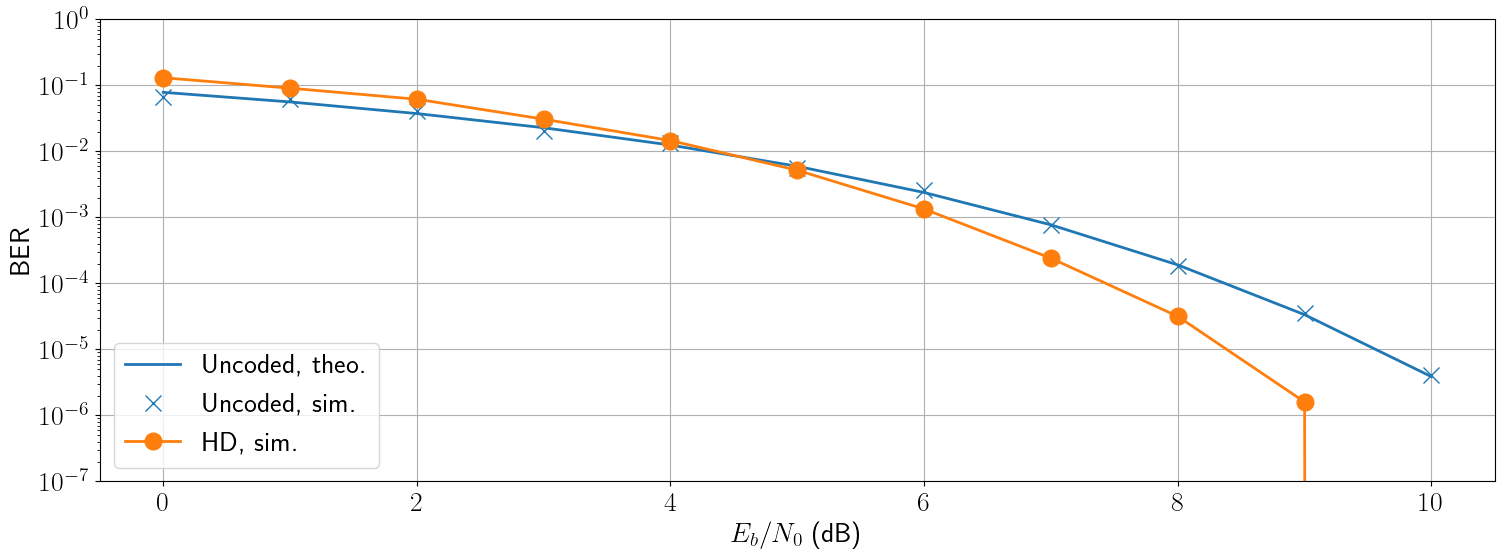

In [12]:
###
# theoretical ber for bpsk as on slides
###

# NOTE: Q(x) = 1 - Phi( x )
ber_bpsk_theo = 1 - stats.norm.cdf( np.sqrt( 2 * EbN0_range ) ) 

        
# plot theoretical curves first and use same color for simulated curve
ax_bpsk = plt.plot( EbN0_db_range, ber_bpsk_theo, linewidth=2.0, label = "Uncoded, theo.")
col_bpsk = ax_bpsk[0].get_color()  
plt.plot( EbN0_db_range, ber_bpsk, 'x', color=col_bpsk, linewidth=2.0, markersize = 12, label = "Uncoded, sim." )

simlabel = "SD, sim." if simulation_SDD == True else "HD, sim."
# plot theoretical curves first and use same color for simulated curve
plt.plot( EbN0_db_range, ber_coded, '-o', markersize = 12, linewidth=2.0, label = simlabel)    


plt.yscale('log')
plt.grid(True)
plt.legend(loc='lower left') 

plt.xlabel('$E_b/N_0$ (dB)')
plt.ylabel('BER')

plt.ylim( (1e-7, 1) )